<a href="https://colab.research.google.com/github/murtazav/Floorplan-object-detection/blob/master/floorplan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/CubiCasa/CubiCasa5k

fatal: destination path 'CubiCasa5k' already exists and is not an empty directory.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd CubiCasa5k/

/content/CubiCasa5k


In [10]:
!ls

 create_lmdb.py			      Dockerfile   LICENSE	      runs_cubi
 data				      eval.py	   README.md	      samples.ipynb
'Difference in Room Annotation.pdf'   floortrans   requirements.txt   train.py


In [6]:
!pip install svgpathtools

In [7]:
!pip install lmdb

In [8]:
%matplotlib inline
import matplotlib
import importlib

# 临时修补matplotlib.cm
matplotlib.cm.register_cmap = lambda *args, **kwargs: None

from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# 导入floortrans前忽略警告
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

# 恢复警告
warnings.filterwarnings("default")

In [9]:
rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

In [10]:
data_folder = '/content/drive/MyDrive/cubicasa5k/'
data_file = 'test.txt'
file_path = os.path.join(data_folder, data_file)
with open(file_path, 'r') as f:
    line_count = len(f.readlines())
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)

In [11]:
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
checkpoint = torch.load('/content/drive/MyDrive/model_best_val_loss_var.pkl')

model.load_state_dict(checkpoint['model_state'])
model.eval()
model.cuda()
print("Model loaded.")

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


Model loaded.


In [12]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 定义颜色
room_colors = ['#FFFFFF', '#8dd3c7', '#ffffb3', '#bebada', '#fb8072',
               '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#bc80bd',
               '#ccebc5', '#ffed6f', '#577a4d']
icon_colors = ['#DCDCDC', '#8dd3c7', '#b15928', '#fdb462', '#ffff99',
               '#b3de69', '#fccde5', '#bc80bd', '#ccebc5', '#ffed6f',
               '#577a4d']

# 版本兼容的注册方式
if hasattr(mpl, 'colormaps'):  # Matplotlib 3.5+
    mpl.colormaps.register(mcolors.ListedColormap(room_colors, name='rooms'))
    mpl.colormaps.register(mcolors.ListedColormap(icon_colors, name='icons'))
else:
    plt.register_cmap(name='rooms', cmap=mcolors.ListedColormap(room_colors))
    plt.register_cmap(name='icons', cmap=mcolors.ListedColormap(icon_colors))

In [13]:
# 1. 修改post_prosessing.py文件
!sed -i "s/wall_width = stats.mode(widths).mode\[0\]/wall_width = float(stats.mode(widths).mode) if len(widths)>0 else min(y2-y1,x2-x1)\/2/" /content/CubiCasa5k/floortrans/post_prosessing.py

# 2. 重新加载模块
import importlib
import floortrans.post_prosessing
importlib.reload(floortrans.post_prosessing)

<module 'floortrans.post_prosessing' from '/content/CubiCasa5k/floortrans/post_prosessing.py'>

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from mpl_toolkits.axes_grid1 import AxesGrid

# 创建输出目录
output_dir = '/content/output'
os.makedirs(output_dir, exist_ok=True)
n_rooms = 12
n_icons = 11
# 处理图片
for i in range(line_count):
    try:
        # 获取数据
        val = next(data_iter)
        junctions = val['heatmaps']
        folder = val['folder'][0]
        image = val['image'].cuda()
        label = val['label']

        # 转换图像格式
        np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
        label_np = label.data.numpy()[0]

        # 预测
        with torch.no_grad():
            height, width = label_np.shape[1], label_np.shape[2]
            rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
            prediction = torch.zeros([len(rotations), n_classes, height, width])

            for j, (forward, back) in enumerate(rotations):
                rot_image = rot(image, 'tensor', forward)
                pred = model(rot_image)
                pred = rot(pred, 'tensor', back)
                pred = rot(pred, 'points', back)
                pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
                prediction[j] = pred[0]

        # 平均预测结果
        prediction = torch.mean(prediction, 0, True)

        # 获取房间和图标预测
        rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy().argmax(0)
        icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy().argmax(0)

        # 多边形提取
        heatmaps, rooms, icons = split_prediction(prediction, (height, width), split)
        polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])
        pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)

        # 保存结果
        save_path = os.path.join(output_dir, f'result_{i+1}')
        os.makedirs(save_path, exist_ok=True)

        # 保存原始图像
        plt.imsave(f'{save_path}/original.png', np_img)

        # 保存SVG文件
        !cp "{data_folder}{folder}model.svg" "{save_path}/" 2>/dev/null || echo "SVG文件未找到"

        # 保存预测结果
        def save_segmentation(seg, classes, cmap, filename, n_classes):
            plt.figure(figsize=(10,10))
            plt.imshow(seg, cmap=cmap, vmin=0, vmax=n_classes-0.1)
            plt.axis('off')
            plt.savefig(f'{save_path}/{filename}', bbox_inches='tight')
            plt.close()

        save_segmentation(label_np[0], room_classes, 'rooms', 'gt_rooms.png', n_rooms)
        save_segmentation(label_np[1], icon_classes, 'icons', 'gt_icons.png', n_icons)
        save_segmentation(rooms_pred, room_classes, 'rooms', 'pred_rooms.png', n_rooms)
        save_segmentation(icons_pred, icon_classes, 'icons', 'pred_icons.png', n_icons)
        save_segmentation(pol_room_seg, room_classes, 'rooms', 'poly_rooms.png', n_rooms)
        save_segmentation(pol_icon_seg, icon_classes, 'icons', 'poly_icons.png', n_icons)

        # 保存关键点图像
        plt.figure(figsize=(10,10))
        plt.imshow(np_img)
        h, w, _ = np_img.shape
        draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
        plt.axis('off')
        plt.savefig(f'{save_path}/junctions.png', bbox_inches='tight')
        plt.close()


        print(f"已处理第 {i+1} 张图片/，结果保存在: {save_path}")

    except Exception as e:
        print(f"处理第 {i+1} 张图片时出错: {str(e)}")
        continue

print("\n所有图片处理完成！结果保存在:", output_dir)
!ls -lh "{output_dir}"

已处理第 1 张图片/，结果保存在: /content/output/result_1
已处理第 2 张图片/，结果保存在: /content/output/result_2
已处理第 3 张图片/，结果保存在: /content/output/result_3
已处理第 4 张图片/，结果保存在: /content/output/result_4
已处理第 5 张图片/，结果保存在: /content/output/result_5
已处理第 6 张图片/，结果保存在: /content/output/result_6
已处理第 7 张图片/，结果保存在: /content/output/result_7
已处理第 8 张图片/，结果保存在: /content/output/result_8
已处理第 9 张图片/，结果保存在: /content/output/result_9
已处理第 10 张图片/，结果保存在: /content/output/result_10
已处理第 11 张图片/，结果保存在: /content/output/result_11
已处理第 12 张图片/，结果保存在: /content/output/result_12
已处理第 13 张图片/，结果保存在: /content/output/result_13
已处理第 14 张图片/，结果保存在: /content/output/result_14
已处理第 15 张图片/，结果保存在: /content/output/result_15
已处理第 16 张图片/，结果保存在: /content/output/result_16
已处理第 17 张图片/，结果保存在: /content/output/result_17
已处理第 18 张图片/，结果保存在: /content/output/result_18
已处理第 19 张图片/，结果保存在: /content/output/result_19
已处理第 20 张图片/，结果保存在: /content/output/result_20
已处理第 21 张图片/，结果保存在: /content/output/result_21
已处理第 22 张图片/，结果保存在: /content/output/result_22
已处理第 2

#Example 1

/content/CubiCasa5k/floortrans/loaders/svg_utils.py:117: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  v = np.matrix([[X[i]], [Y[i]], [1]])
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:120: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i] = new_x
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:121: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[i] = new_y
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:124: PendingDeprecati

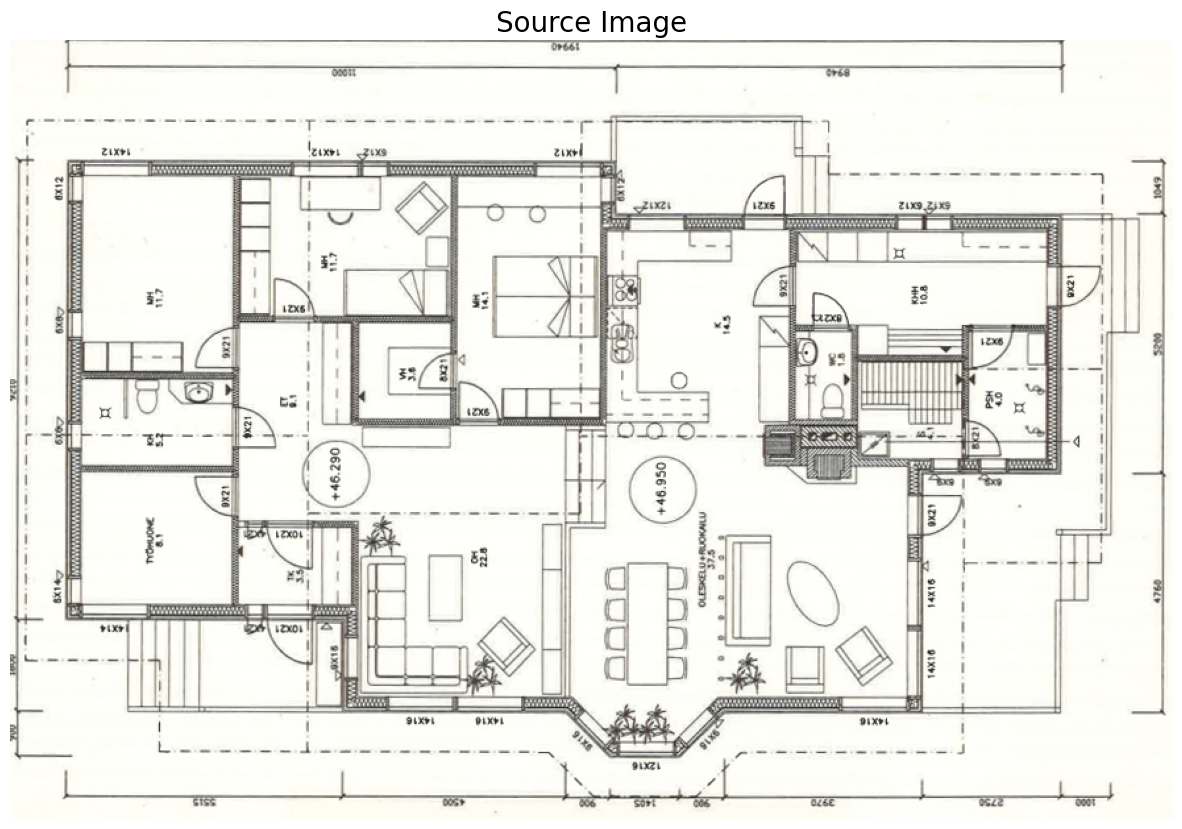

In [14]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image'].cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(15,15))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

In [15]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= data_folder+folder+"model.svg", width=800)

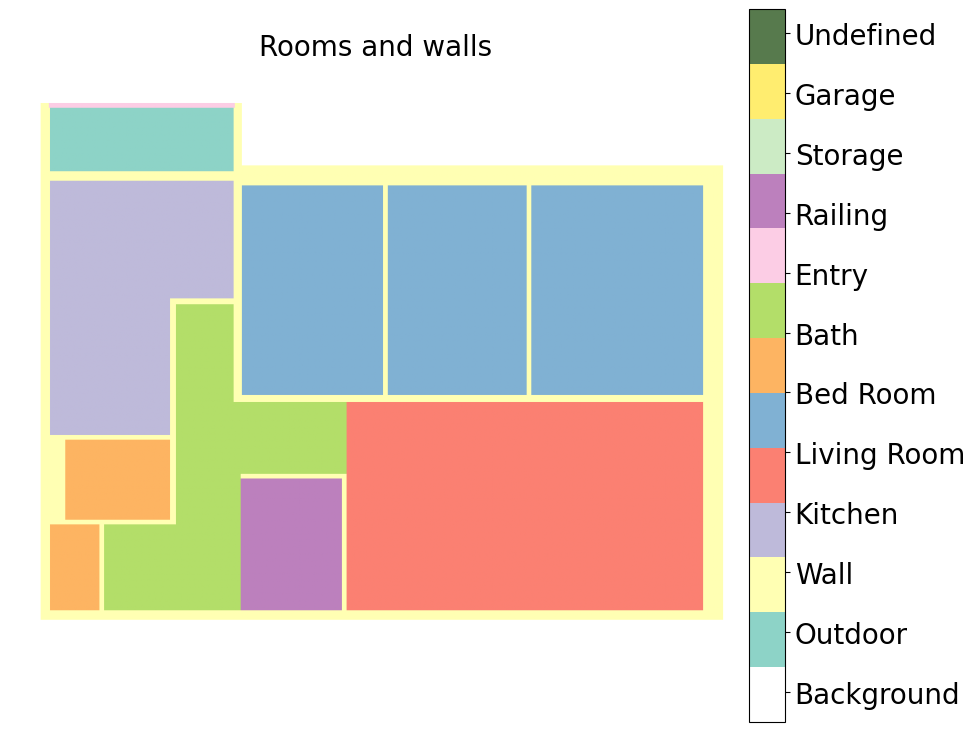

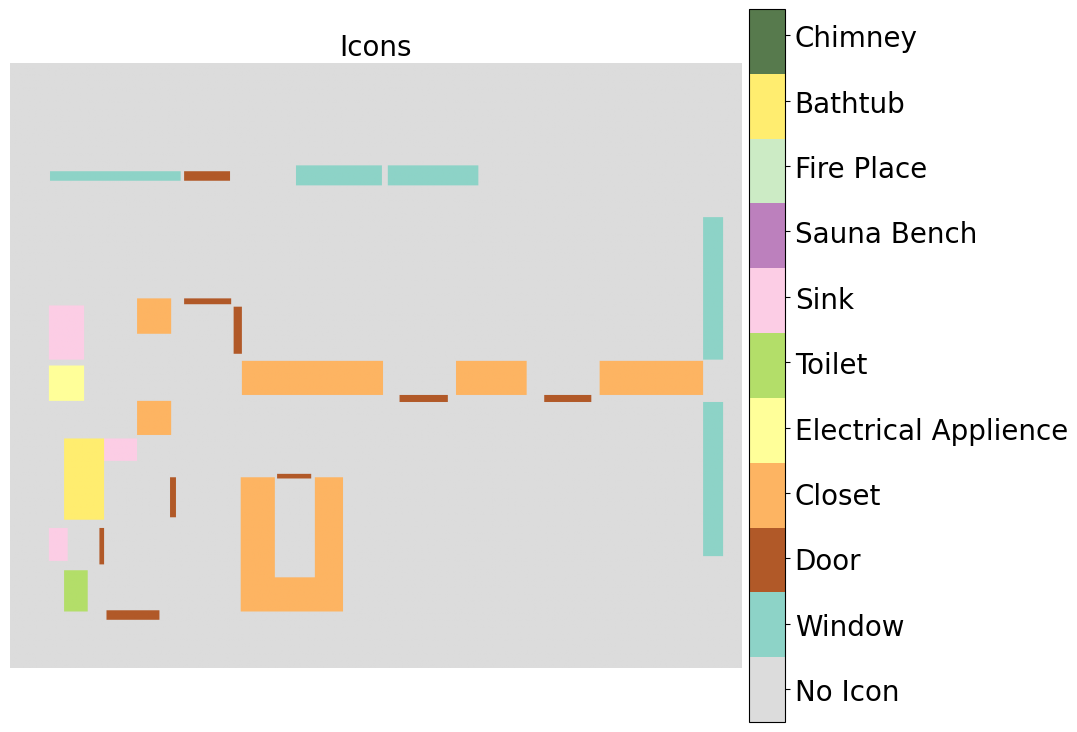

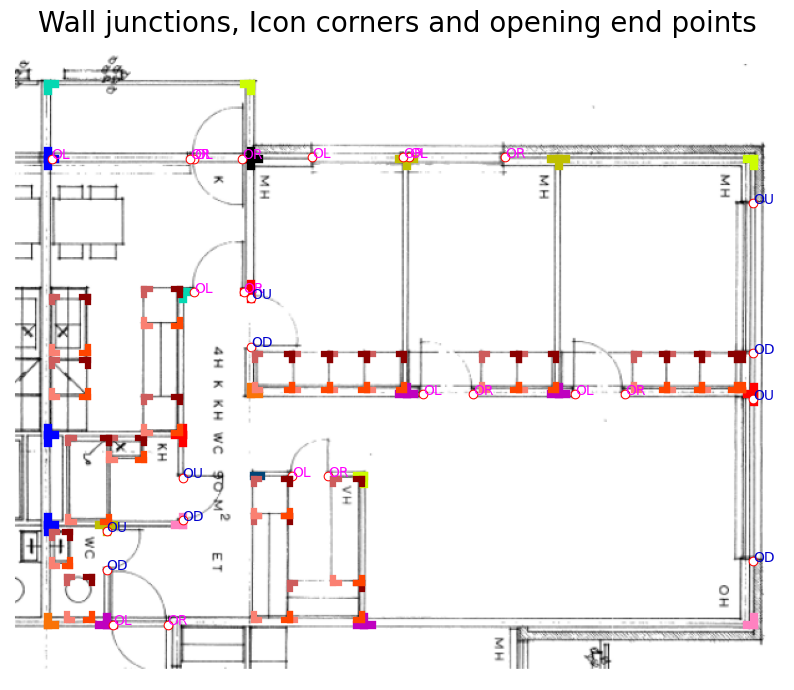

In [38]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

#Segmentation prediction

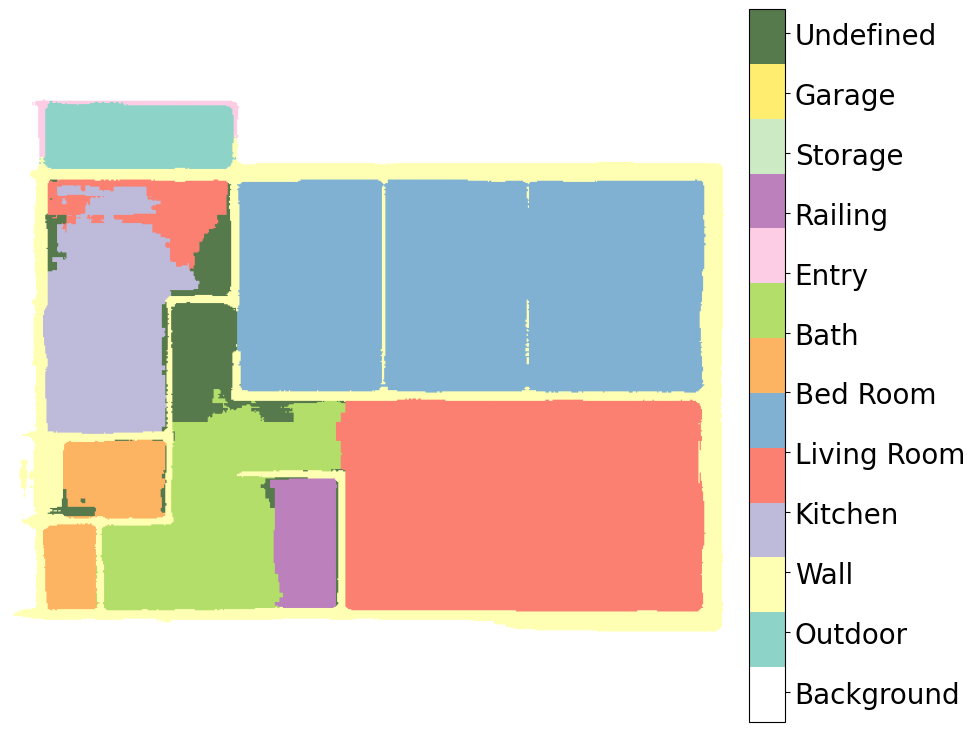

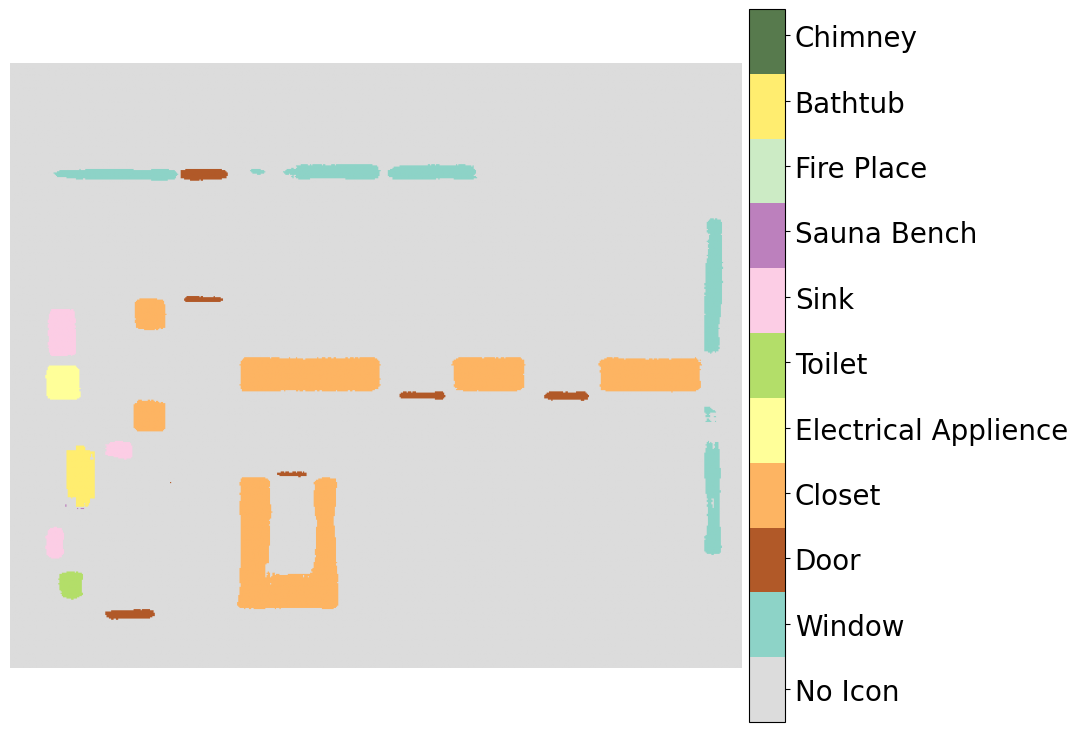

In [39]:
with torch.no_grad():
    height = label_np.shape[1]
    width = label_np.shape[2]
    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
rooms_label = label_np[0]
icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(rooms_pred, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(icons_pred, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

#Post-Processing

In [40]:
# 1. 修改post_prosessing.py文件
!sed -i "s/wall_width = stats.mode(widths).mode\[0\]/wall_width = float(stats.mode(widths).mode) if len(widths)>0 else min(y2-y1,x2-x1)\/2/" /content/CubiCasa5k/floortrans/post_prosessing.py

# 2. 重新加载模块
import importlib
import floortrans.post_prosessing
importlib.reload(floortrans.post_prosessing)



<frozen importlib._bootstrap>:1047: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


<module 'floortrans.post_prosessing' from '/content/CubiCasa5k/floortrans/post_prosessing.py'>

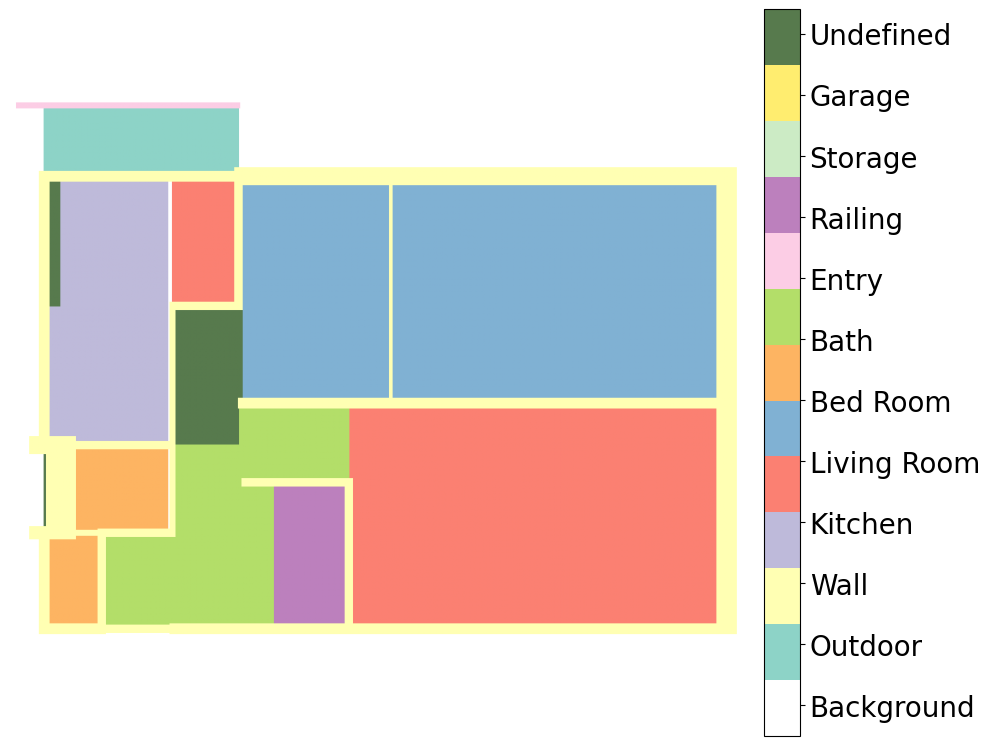

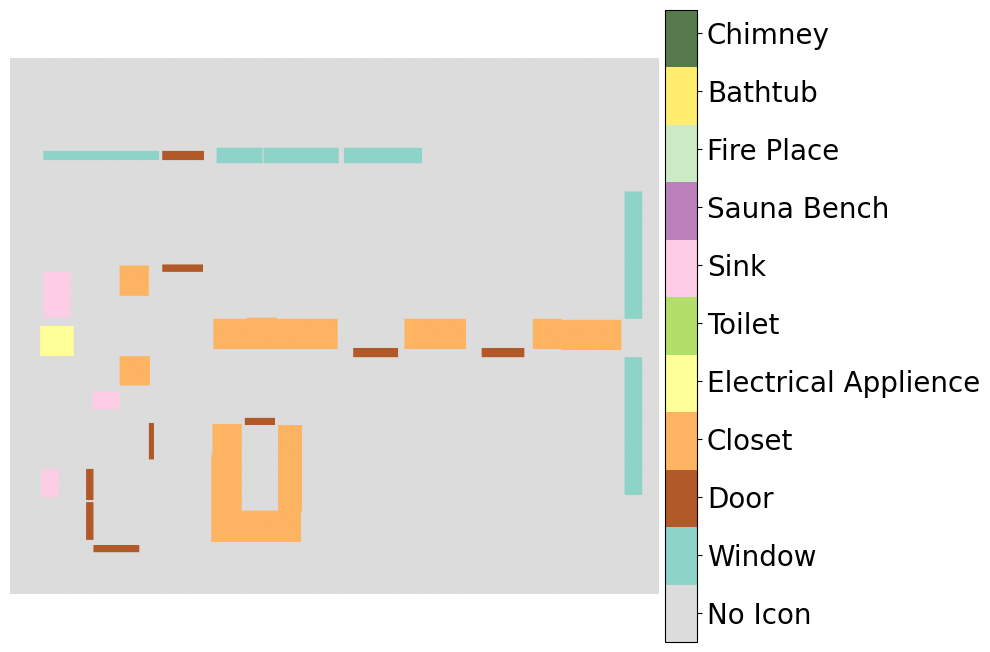

In [41]:
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

#Comparision between Actual and Predicted Segmentation

<ipython-input-43-1a60664e50f8>:13: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 2000x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = ax.cax.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5)


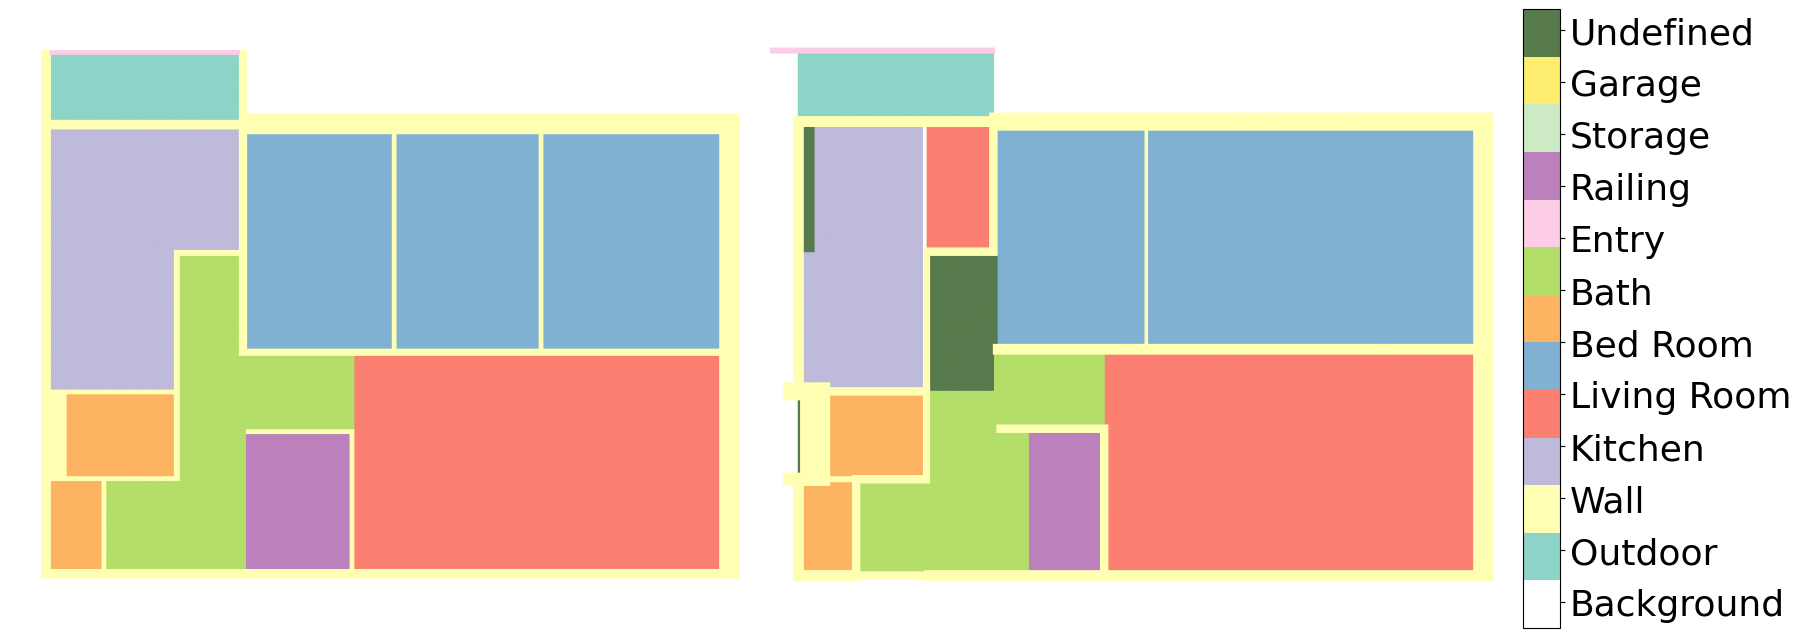

In [43]:
fig = plt.figure(figsize=(20, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )
images = [label_np[0], pol_room_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = ax.cax.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5)
cbar.ax.set_yticklabels(room_classes, fontsize=26)
plt.show()

<ipython-input-44-8db1e0ba0313>:15: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 2000x1200 with 4 Axes> which fig.colorbar is called on.
  cbar = ax.cax.colorbar(iseg, ticks=np.arange(n_icons) + 0.5)


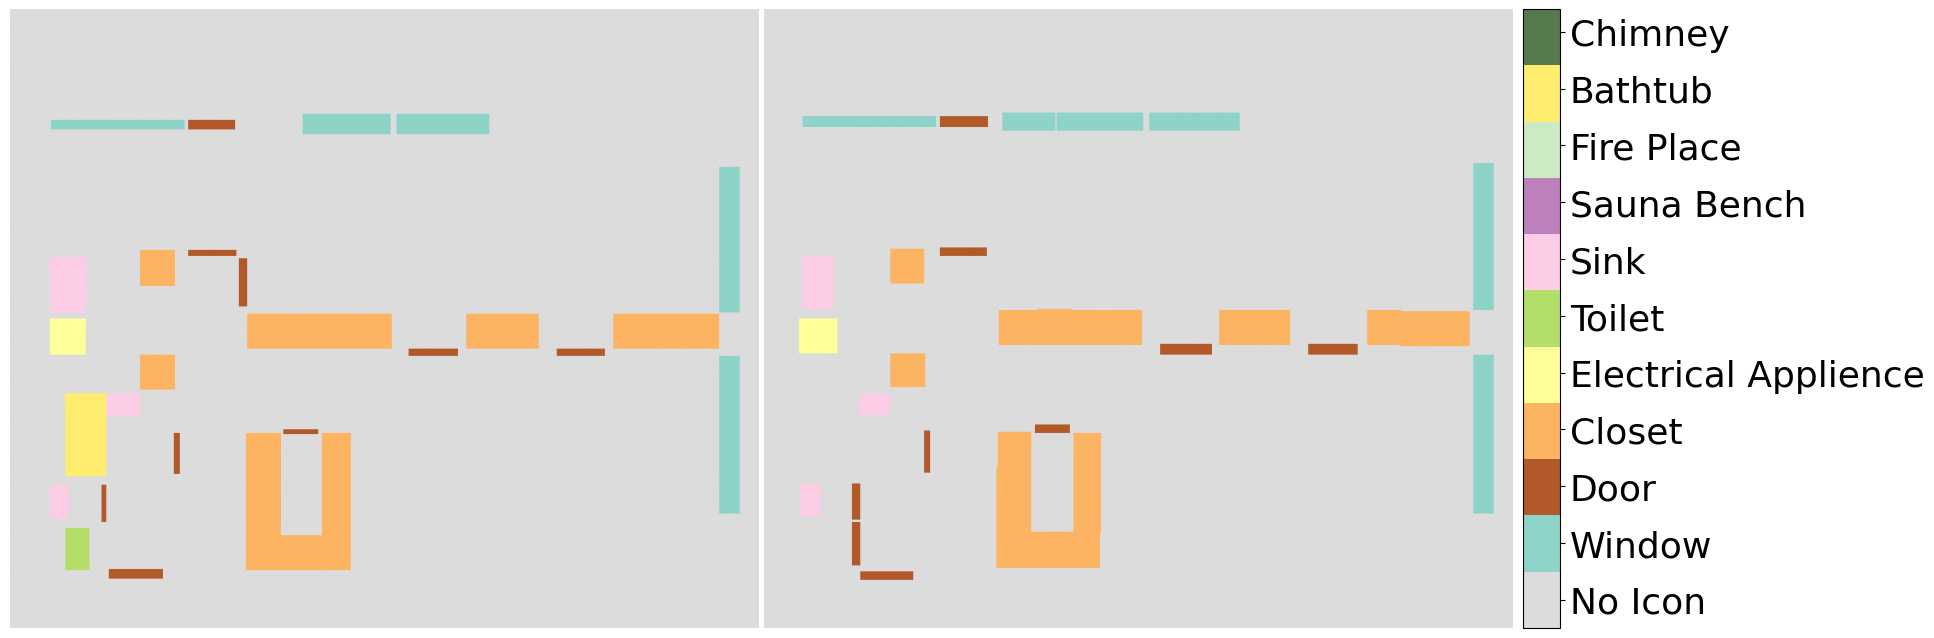

In [44]:
fig = plt.figure(figsize=(20, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 2),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

images = [label_np[1], pol_icon_seg]
for i, ax in enumerate(grid):
    ax.set_axis_off()
    im = ax.imshow(images[i], cmap='icons', vmin=0, vmax=n_icons-0.1)

cbar = ax.cax.colorbar(iseg, ticks=np.arange(n_icons) + 0.5)
cbar.ax.set_yticklabels(icon_classes, fontsize=26)
plt.show()